<img align="left" src="https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/CC_BY.png"><br />

Created by [Nathan Kelber](http://nkelber.com) and Ted Lawless for [JSTOR Labs](https://labs.jstor.org/) under [Creative Commons CC BY License](https://creativecommons.org/licenses/by/4.0/)<br />
For questions/comments/improvements, email nathan.kelber@ithaka.org.<br />
____
# Exploring Word Frequencies in Vita & Pensiero publications

**Description:**
This [notebook](https://docs.constellate.org/key-terms/#jupyter-notebook) shows how to find the most common words in a
[dataset](https://docs.constellate.org/key-terms/#dataset). The following processes are described:

* Using the `constellate` client to create a Pandas DataFrame
* Filtering based on a pre-processed ID list
* Filtering based on a [stop words list](https://docs.constellate.org/key-terms/#stop-words)
* Using a `Counter()` object to get the most common words

**Use Case:** For Learners (Detailed explanation, not ideal for researchers)

[Take me to the **Research Version** of this notebook ->](./exploring-word-frequencies-for-research.ipynb)

**Difficulty:** Intermediate

**Completion time:** 60 minutes

**Knowledge Required:** 
* Python Basics ([Start Python Basics I](./python-basics-1.ipynb))

**Knowledge Recommended:**

* [Working with Dataset Files](./working-with-dataset-files.ipynb)
* [Pandas I](./pandas-1.ipynb)
* [Counter Objects](./counter-objects.ipynb)
* [Creating a Stopwords List](./creating-stopwords-list.ipynb)

**Data Format:** [JSON Lines (.jsonl)](https://docs.constellate.org/key-terms/#jsonl)

**Libraries Used:**
* [constellate](https://docs.constellate.org/key-terms/#tdm-client) client to collect, unzip, and read our dataset
* [NLTK](https://docs.constellate.org/key-terms/#nltk) to help [clean](https://docs.constellate.org/key-terms/#clean-data) up our dataset
* [Counter](https://docs.constellate.org/key-terms/#python-counter) from **Collections** to help sum up our word frequencies

**Research Pipeline:**

1. Build a dataset
2. Create a "Pre-Processing CSV" with [Exploring Metadata](./exploring-metadata.ipynb) (Optional)
3. Create a "Custom Stopwords List" with [Creating a Stopwords List](./creating-stopwords-list.ipynb) (Optional)
4. Complete the word frequencies analysis with this notebook
___

## Import your dataset

We'll use the `constellate` client to automatically retrieve the dataset in the JSON file format. 

Enter a [dataset ID](https://docs.constellate.org/key-terms/#dataset-ID) in the next code cell.

If you don't have a dataset ID, you can:
* Use the sample dataset ID already in the code cell
* [Create a new dataset](https://constellate.org/builder)
* [Use a dataset ID from other pre-built sample datasets](https://constellate.org/dataset/dashboard)

In [1]:
# Creating a variable `dataset_id` to hold our dataset ID
# The default dataset is Shakespeare Quarterly, 1950-present
dataset_id = "f940f9c4-5f65-1095-9409-00f920d71acf"

Next, import the `constellate` client, passing the `dataset_id` as an argument using the `get_dataset` method.

In [2]:
# Importing your dataset with a dataset ID
import constellate
# Pull in the sampled dataset (1500 documents) that matches `dataset_id`
# in the form of a gzipped JSON lines file.
# The .get_dataset() method downloads the gzipped JSONL file
# to the /data folder and returns a string for the file name and location
dataset_file = constellate.get_dataset(dataset_id)

# To download the full dataset (up to a limit of 25,000 documents),
# request it first in the builder environment. See the Constellate Client
# documentation at: https://constellate.org/docs/constellate-client
# Then use the `constellate.download` method show below.
#dataset_file = constellate.download(dataset_id, 'jsonl')

Constellate: use and download of datasets is covered by the Terms & Conditions of Use: https://constellate.org/terms-and-conditions/
All documents from JSTOR published by Vita e Pensiero – Pubblicazioni dell’Università Cattolica del Sacro Cuore from 1918 - 2022. 40174 documents.
INFO:root:Downloading f940f9c4-5f65-1095-9409-00f920d71acf metadata to /root/data/f940f9c4-5f65-1095-9409-00f920d71acf-sampled-jsonl.jsonl.gz


100% |########################################################################|


## Apply Pre-Processing Filters (if available)
If you completed pre-processing with the "Exploring Metadata and Pre-processing" notebook, you can use your CSV file of dataset IDs to automatically filter the dataset. Your pre-processed CSV file should be in the /data directory.

In [3]:
# Import a pre-processed CSV file of filtered dataset IDs.
# If you do not have a pre-processed CSV file, the analysis
# will run on the full dataset and may take longer to complete.
import pandas as pd
import os

# Define a string that describes the path to the CSV
pre_processed_file_name = f'data/pre-processed_{dataset_id}.csv'

# Test if the path to the CSV exists
# If true, then read the IDs into filtered_id_list
if os.path.exists(pre_processed_file_name):
    df = pd.read_csv(pre_processed_file_name)
    filtered_id_list = df["id"].tolist()
    use_filtered_list = True
    print(f'Pre-Processed CSV found. Filtered dataset is ' + str(len(df)) + ' documents.')
else: 
    use_filtered_list = False
    print('No pre-processed CSV file found. Full dataset will be used.')

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
No pre-processed CSV file found. Full dataset will be used.


## Extract Unigram Counts from the JSON file (No cleaning)

We pulled in our dataset using a `dataset_id`. The file, which resides in the datasets/ folder, is a compressed JSON Lines file (jsonl.gz) that contains all the metadata information found in the metadata CSV *plus* the textual data necessary for analysis including:

* Unigram Counts
* Bigram Counts
* Trigram Counts
* Full-text (if available)

To complete our analysis, we are going to pull out the unigram counts for each document and store them in a Counter() object. We will import `Counter` which will allow us to use Counter() objects for counting unigrams. Then we will initialize an empty Counter() object `word_frequency` to hold all of our unigram counts.

In [4]:
# Import Counter()
from collections import Counter

# Create an empty Counter object called `word_frequency`
word_frequency = Counter()

We can read in each document using the tdm_client.dataset_reader. 

In [5]:
# Gather unigramCounts from documents in `filtered_id_list` if it is available

for document in constellate.dataset_reader(dataset_file):
    if use_filtered_list is True:
        document_id = document['id']
        # Skip documents not in our filtered_id_list
        if document_id not in filtered_id_list:
            continue
    unigrams = document.get("unigramCount", [])
    for gram, count in unigrams.items():
        word_frequency[gram] += count

# Print success message
if use_filtered_list is True:
    print('Unigrams have been collected only for the ' + str(len(df)) + ' documents listed in your CSV file.')
else:
    print('Unigrams have been collected for all documents without filtering from a CSV file.')

Unigrams have been collected for all documents without filtering from a CSV file.


### Find Most Common Unigrams
Now that we have a list of the frequency of all the unigrams in our corpus, we need to sort them to find which are most common

In [6]:
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

di                   161447
e                    111040
in                   72046
la                   69201
che                  66594
il                   58454
del                  54335
a                    49025
della                45469
per                  35464
si                   33817
non                  33184
un                   32290
una                  28493
-                    27837
è                    26709
le                   26048
da                   23826
con                  21944
i                    21842
dei                  20382
nel                  18835
come                 18303
al                   17973
delle                17793


### Some issues to consider

We have successfully created a word frequency list. There are a couple small issues, however, that we still need to address:
1. There are many [function words](https://docs.constellate.org/key-terms/#function-words), words like "the", "in", and "of" that are grammatically important but do not carry as much semantic meaning like [content words](https://docs.constellate.org/key-terms/#content-words), such as nouns and verbs.
2. The words represented here are actually case-sensitive [strings](https://docs.constellate.org/key-terms/#string). That means that the string "the" is a different from the string "The". You may notice this in your results above.



## Extract Unigram Counts from the JSON File (with cleaning)
To address these issues, we need to find a way to remove common [function words](https://docs.constellate.org/key-terms/#function-words) and combine [strings](https://docs.constellate.org/key-terms/#string) that may have capital letters in them. We can address these issues by:

1. Using a [stopwords](https://docs.constellate.org/key-terms/#stop-words) list to remove common [function words](https://docs.constellate.org/key-terms/#function-words)
2. Lowercasing all the characters in each string to combine our counts

### Load Stopwords List

If you have created a stopword list in the stopwords notebook, we will import it here. (You can always modify the CSV file to add or subtract words then reload the list.) Otherwise, we'll load the NLTK [stopwords](https://docs.constellate.org/key-terms/#stop-words) list automatically.

In [9]:
# Load a custom data/stop_words.csv if available
# Otherwise, load the nltk stopwords list in English

# Create an empty Python list to hold the stopwords
stop_words = []

# The filename of the custom data/stop_words.csv file
stopwords_list_filename = 'data/stop_words_italian.csv'

if os.path.exists(stopwords_list_filename):
    import csv
    with open(stopwords_list_filename, 'r') as f:
        stop_words = list(csv.reader(f))[0]
    print('Custom stopwords list loaded from CSV')
else:
    # Load the NLTK stopwords list
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    print('NLTK stopwords list loaded')

Custom stopwords list loaded from CSV


In [19]:
# Preview stop words
list(stop_words)
stop_words = stop_words + ['alia'] + ['that'] + ['zione'] + ['viene'] + ['essa'] + ['esso']

### Modify Stopwords List
The following code examples can be used to modify a stopwords list. We recommend storing your stopwords in a CSV file as shown in the [Creating Stopwords List](./creating-stopwords-list.ipynb) notebook.

|code|change|
|---|---|
|stop_words.append('word_to_add')| Append a single word to the list|
|stop_words = stop_words + ['word_one', 'word_two', 'word_three']| Concatenate multiple words to the list|
|stop_words.remove('word_to_remove')| Delete a word from the list|

### Gather unigrams again with extra cleaning steps
In addition to using a stopwords list, we will clean up the tokens by lowercasing all tokens and combining them. This will combine tokens with different capitalization such as "quarterly" and "Quarterly." We will also remove any tokens that are not alphanumeric.

In [20]:
# Gather unigramCounts from documents in `filtered_id_list` if available
# and apply the processing.

word_frequency = Counter()

for document in constellate.dataset_reader(dataset_file):
    if use_filtered_list is True:
        document_id = document['id']
        # Skip documents not in our filtered_id_list
        if document_id not in filtered_id_list:
            continue
    unigrams = document.get("unigramCount", [])
    for gram, count in unigrams.items():
        clean_gram = gram.lower()
        if clean_gram in stop_words:
            continue
        if not clean_gram.isalpha():
            continue
        if len(clean_gram) < 4:
            continue
        word_frequency[clean_gram] += count

## Display Results
Finally, we will display the 20 most common words by using the `.most_common()` method on the `Counter()` object.

In [21]:
# Print the most common processed unigrams and their counts
for gram, count in word_frequency.most_common(25):
    print(gram.ljust(20), count)

storia               3405
milano               2926
pensiero             2916
lavoro               2848
filosofia            2683
senso                2477
problema             2471
punto                2293
studi                2214
chiesa               2039
sociale              2030
politica             2027
particolare          2011
mente                1909
valore               1899
studio               1892
sistema              1861
forma                1856
rapporto             1809
cura                 1807
base                 1763
volume               1752
ricerca              1733
maria                1694
possono              1675


## Export Results to a CSV File
The word frequency data can be exported to a CSV file.

In [22]:
# Add output method to csv
import csv

with open(f'./data/word_frequencies_{dataset_id}.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['unigram', 'count'])
    for gram, count in word_frequency.most_common():
        writer.writerow([gram, count])
    

## Create a Word Cloud to Visualize the Data
A visualization using the WordCloud library in Python. To learn more about customizing a wordcloud, [see the documentation](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html). 

In [23]:
# Add wordcloud
from wordcloud import WordCloud
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
### Download cloud image for our word cloud shape
import urllib.request
download_url = 'https://ithaka-labs.s3.amazonaws.com/static-files/images/tdm/tdmdocs/sample_cloud.png'
urllib.request.urlretrieve(download_url, './data/sample_cloud.png')

('./data/sample_cloud.png', <http.client.HTTPMessage at 0x7fcfe35857c0>)

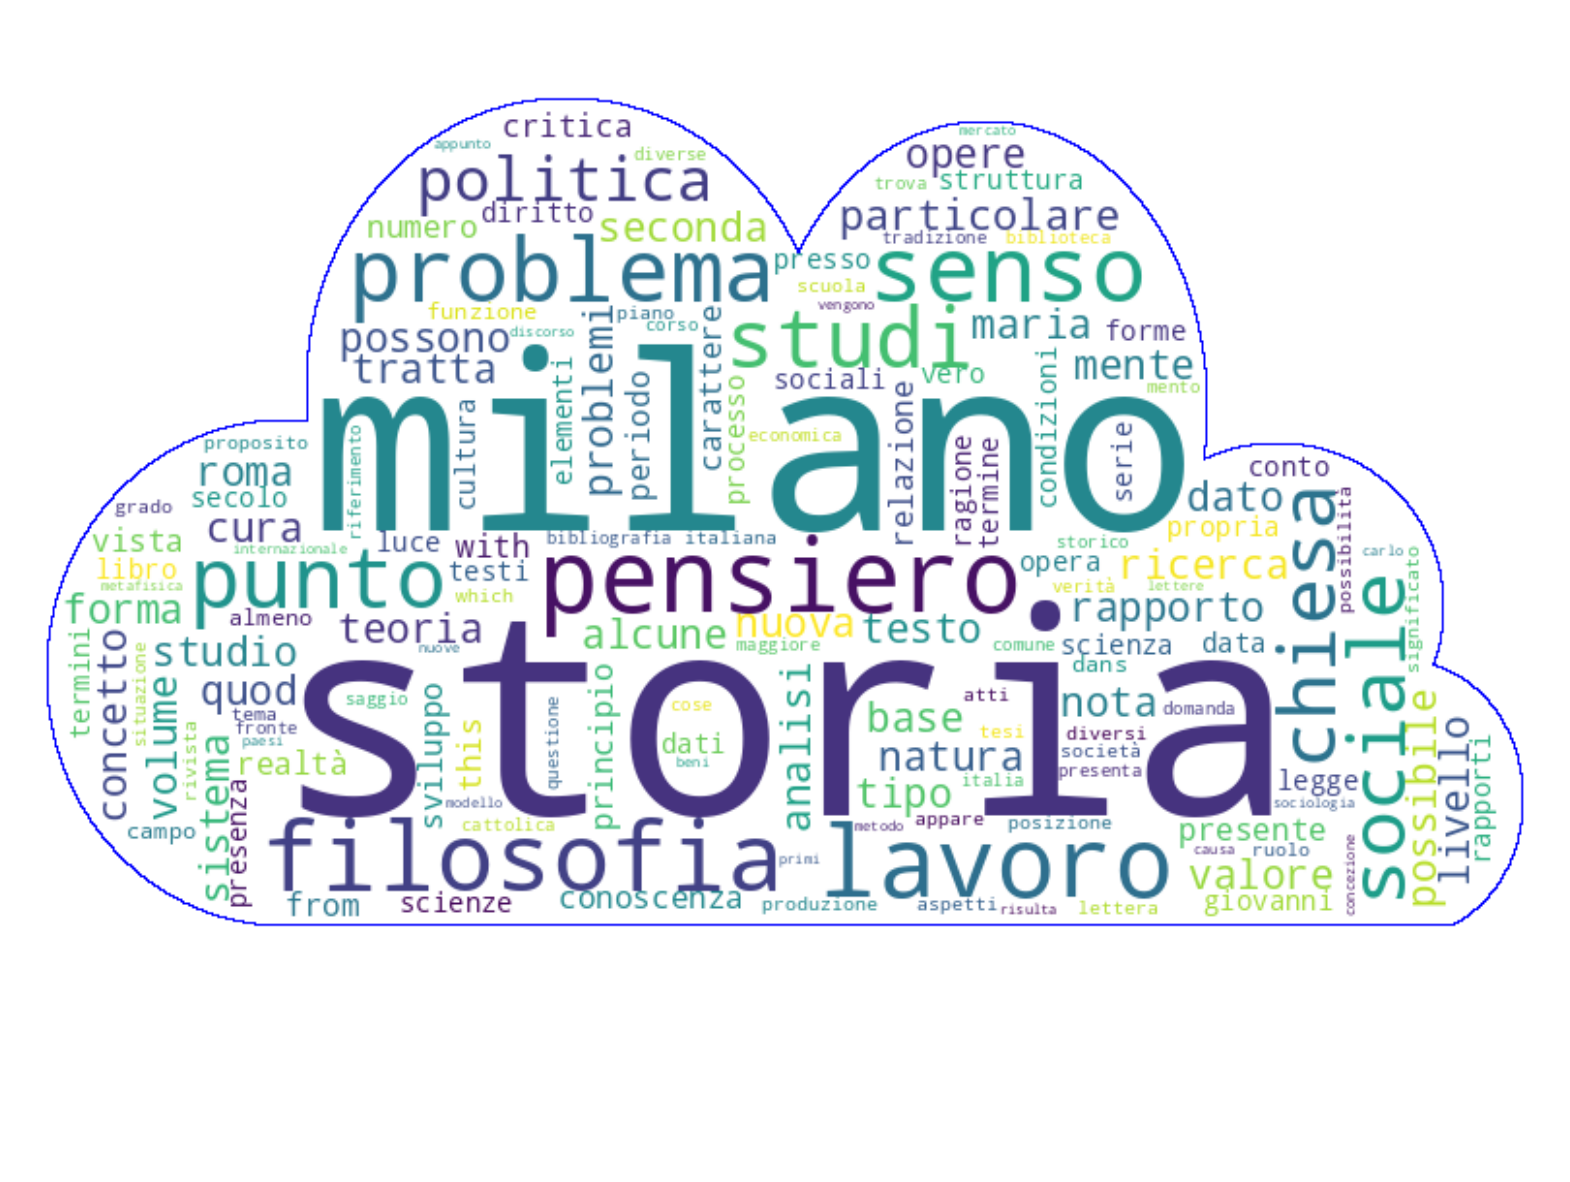

In [25]:
# Create a wordcloud from our data

# Adding a mask shape of a cloud to your word cloud
# By default, the shape will be a rectangle
# You can specify any shape you like based on an image file
cloud_mask = np.array(Image.open('./data/sample_cloud.png')) # Specifies the location of the mask shape
cloud_mask = np.where(cloud_mask > 3, 255, cloud_mask) # this line will take all values greater than 3 and make them 255 (white)

### Specify word cloud details
wordcloud = WordCloud(
    width = 800, # Change the pixel width of the image if blurry
    height = 600, # Change the pixel height of the image if blurry
    background_color = "white", # Change the background color
    colormap = 'viridis', # The colors of the words, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
    max_words = 150, # Change the max number of words shown
    min_font_size = 4, # Do not show small text
    
    # Add a shape and outline (known as a mask) to your wordcloud
    contour_color = 'blue', # The outline color of your mask shape
    mask = cloud_mask, # 
    contour_width = 1
).generate_from_frequencies(word_frequency)

mpl.rcParams['figure.figsize'] = (20,20) # Change the image size displayed
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()